# LDA Mallet TopicModeling

## Trump Tweet Analysis

In [1]:
import re
import numpy as np
import pandas as pd
import timeit
import string
import gensim
import pickle
import nltk
from gensim import models, corpora
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from tqdm.notebook import tnrange
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

stopwords = nltk.corpus.stopwords.words('english')
stopwords += ['amp','rt','u']
wn = WordNetLemmatizer()

df = pd.read_csv('TrumpTweet.csv')
df2 = df[df['is_retweet']==False][['created_at','text']]
doc_full = df2['text'].to_list()

In [2]:
print("Number of Tweet: {}".format(len(df2)))

Number of Tweet: 25963


## Clean data and prepocess

In [3]:
def tweet_cleaner2(text):
    # remove mention
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    # remove website
    text = re.sub(r'https?://[A-Za-z0-9./]+', '',text)
    # remove non-ASCII
    text = re.sub(r'[^\x00-\x7F]+',' ', text)
    # nlp preprocessing
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [word for word in tokens if word not in stopwords]
    text = bigram_mod[text]
    text = [wn.lemmatize(word) for word in text]
    text = [word for word in text if len(word) >1]
    return text

start = timeit.default_timer()
# bigram mode
bigram = gensim.models.Phrases([i.split() for i in doc_full], min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
# clean data
doc_clean = [tweet_cleaner2(doc) for doc in doc_full]
stop = timeit.default_timer()
print('Time: ', stop - start)

Time:  9.580230194


## Create corpus and dictionary

In [38]:
id2word = corpora.Dictionary(doc_clean)
id2word.filter_extremes(no_below=5)
corpus = [id2word.doc2bow(doc) for doc in doc_clean]
# tfidf = models.TfidfModel(corpus)
# corpus_tfidf = tfidf[corpus]
mallet_path = 'mallet-2.0.8/bin/mallet'

## Tune LDA Mallet Model

In [39]:
score_list = []
ldamallet_models = []
for num_topics in tnrange(5,20):
    print ('No. topics: {}'.format(num_topics))
    ldamodel = gensim.models.wrappers.LdaMallet(mallet_path, 
                                                corpus=corpus, 
                                                num_topics=num_topics, 
                                                id2word=id2word)
    coherence_model_lda = CoherenceModel(model=ldamodel, 
                                        texts=doc_clean, 
                                        dictionary=id2word, 
                                        coherence='c_v')
    score = coherence_model_lda.get_coherence()
    score_list.append(score)
    print('Score: {}'.format(score))
    ldamallet_models.append(ldamodel)

  0%|          | 0/15 [00:00<?, ?it/s]

No. topics: 5
Score: 0.4335583100708863
No. topics: 6
Score: 0.4312499084886216
No. topics: 7
Score: 0.4249348057972147
No. topics: 8
Score: 0.45542918139886085
No. topics: 9
Score: 0.47274959481646245
No. topics: 10
Score: 0.44247464150731275
No. topics: 11
Score: 0.47213828674606295
No. topics: 12
Score: 0.4264648656322447
No. topics: 13
Score: 0.4374201913901726
No. topics: 14
Score: 0.41430142974912465
No. topics: 15
Score: 0.4147475590143335
No. topics: 16
Score: 0.44252283356228517
No. topics: 17
Score: 0.4497062054071427
No. topics: 18
Score: 0.435265684826811
No. topics: 19
Score: 0.44138481774049115


## Optimal Model

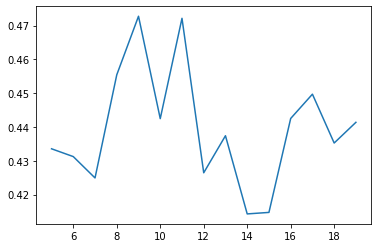

In [40]:
X = [i for i in range(5,20)]

fig, ax = plt.subplots()
ax.plot(X, score_list)

Model have 6 topics have high score and less topic

In [41]:
lda_model = ldamallet_models[4]

## Results

In [42]:
topics = [[(term, round(wt, 3)) for term, wt in lda_model.show_topic(n, topn=20)] 
          for n in range(0, lda_model.num_topics)]

In [43]:
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], 
                         columns = ['Terms per Topic'], 
                         index=['Topic'+str(t) for t in range(1, lda_model.num_topics+1)] )
topics_df.to_csv('model_topics.csv')
topics_df

<ipython-input-43-90961a8a7af7>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Terms per Topic
Topic1,"president, trump, election, poll, show, day, watch, news, washington, true, live, donald, political, 2016, presidential, office, called, force, greatest, interview"
Topic2,"year, country, job, china, back, economy, million, number, usa, trade, world, money, good, record, dollar, billion, coming, including, business, tariff"
Topic3,"great, military, total, love, strong, crime, support, endorsement, job, governor, state, honor, congratulation, complete, senator, woman, incredible, amendment, vet, fight"
Topic4,"time, people, american, thing, administration, family, long, york, general, obama, week, friend, coronavirus, remember, terrible, thought, hope, action, open, month"
Topic5,"democrat, republican, biden, joe, dems, history, party, senate, impeachment, call, pelosi, schiff, nancy, wrong, radical_left, crazy, run, sleepy, left, read"
Topic6,"people, american, border, country, work, wall, bill, stop, order, end, law, government, mexico, give, back, city, act, important, problem, congress"
Topic7,"great, america, big, vote, make, win, tonight, twitter, maga, day, court, florida, john, join, carolina, rally, trump2016, pennsylvania, tomorrow, crowd"
Topic8,"fake_news, medium, hillary, bad, clinton, russia, campaign, story, crooked, fbi, report, hunt, witch, totally, mueller, collusion, case, corrupt, fake, wow"
Topic9,"state, today, house, united, deal, good, made, north, white, meeting, leader, happy, pm, talk, enjoy, morning, korea, continue, iran, statement"


In [48]:
# getting topic for each document
tm_results = lda_model[corpus]
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]

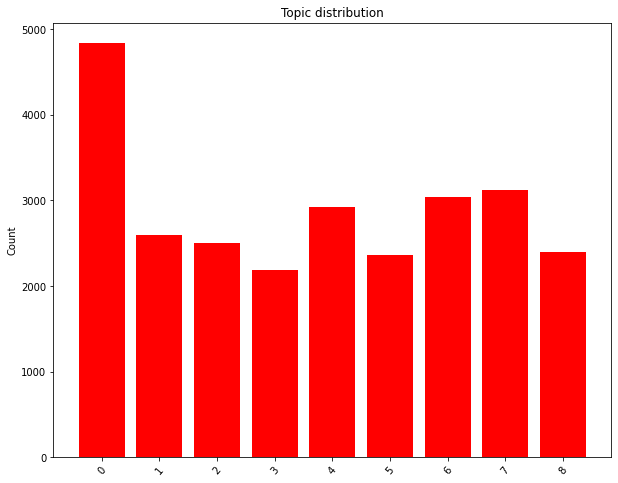

In [49]:
x = [str(i) for i in range(len(topics_df))]
y = []
for i in range(len(topics_df)):
    # getting topic text
    topic_index = [j for j, value in enumerate(corpus_topics) if value[0] == i]
    y.append(len(topic_index))

plt.figure(figsize=[10,8])
plt.bar(x, y, color='red')
plt.ylabel("Count")
plt.title("Topic distribution")
plt.xticks(rotation=50)
plt.show()

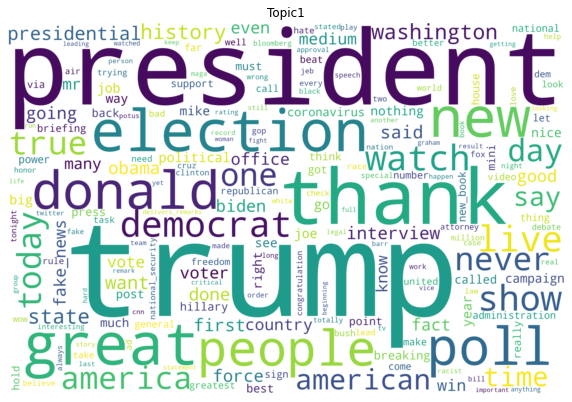

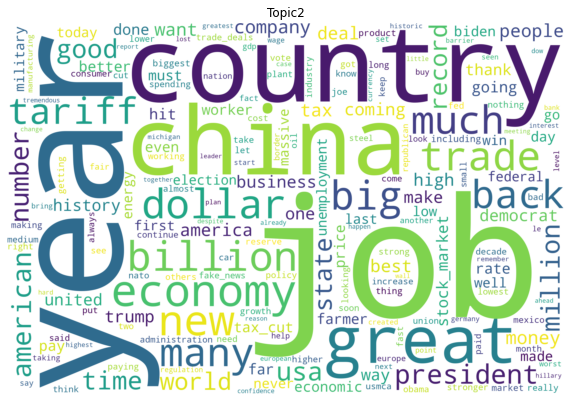

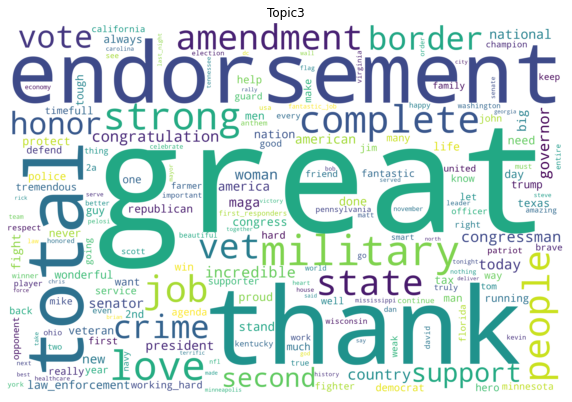

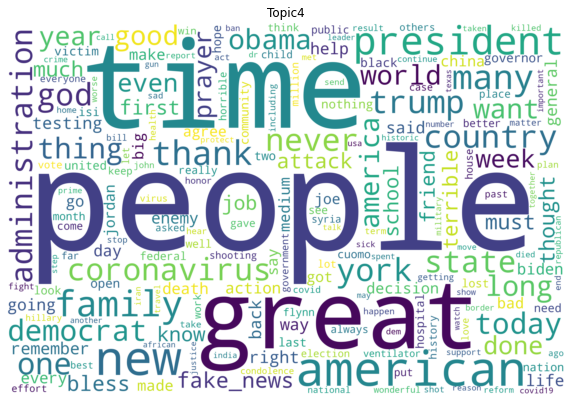

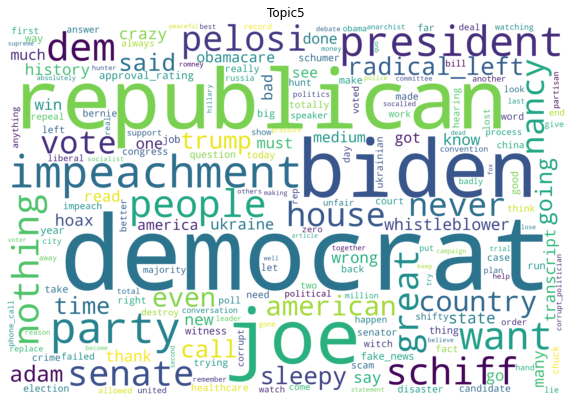

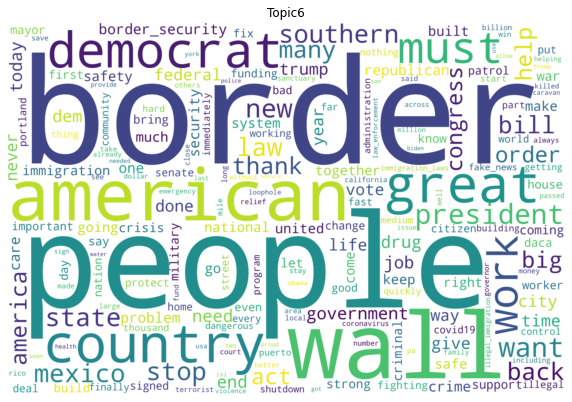

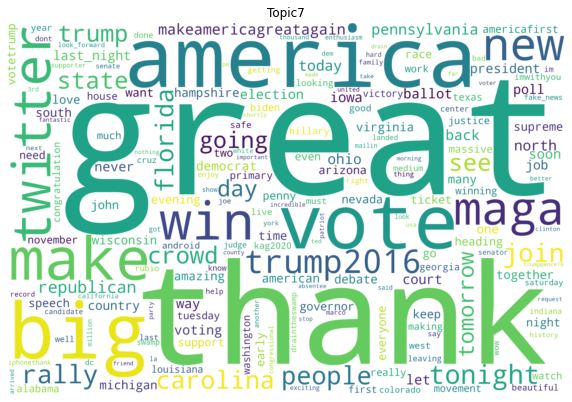

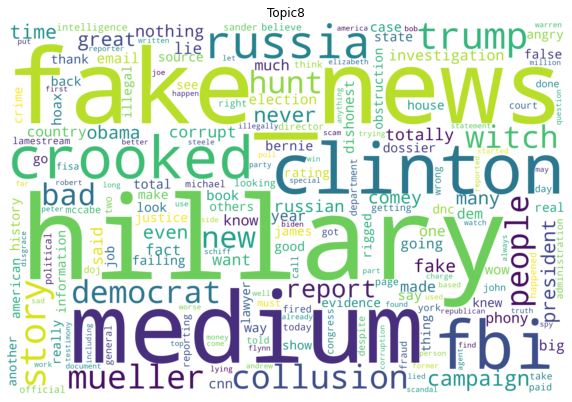

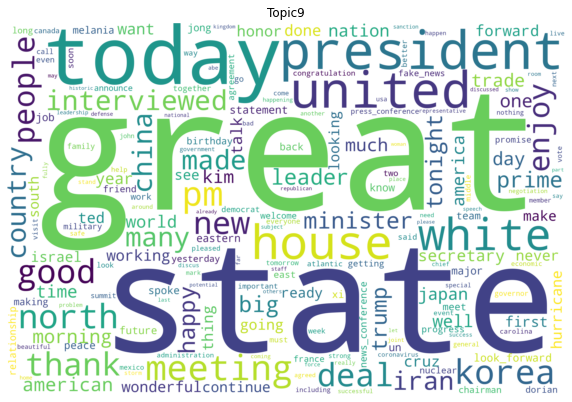

In [51]:
# initiate wordcloud object
wc = WordCloud(width = 3000, 
               height = 2000,
               background_color="white", 
               collocations=False,
               random_state=42)

# Create word cloud plots for each topic
for i in range(len(topics_df)):
    # getting topic text
    topic_index = [j for j, value in enumerate(corpus_topics) if value[0] == i]
    topic_text = [doc_clean[i] for i in topic_index]
    topic_text = [' '.join(topic_text[i]) for i in range(len(topic_text))]
    topic_text = ' '.join(topic_text)
    
    # plot
    wc.generate(text=topic_text)
    plt.figure(figsize=(10, 8))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])
    plt.show()
